In [190]:
import pandas as pd
import numpy as np
import operator
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import math 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [7]:
df = pd.read_csv("time_series_covid_19_confirmed.csv", sep=",")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20,5/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,8676,9216,9998,10582,11173,11831,12456,13036,13659,14525
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,969,981,989,998,1004,1029,1050,1076,1099,1122
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7728,7918,8113,8306,8503,8697,8857,8997,9134,9267
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,762,762,762,763,763,763,763,764,764
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,58,60,61,69,70,70,71,74,81,84


In [147]:

coun=df.set_index('Country/Region').iloc[:,3:-3]
countries=coun.index.drop_duplicates()
coun=coun.T
pak_data=coun['Pakistan']
correlation={}
for country in countries:
    dfr1=coun[country]
    if isinstance(dfr1,pd.core.series.Series):
            x_ax=dfr1
        
    else:
            x_ax=dfr1.sum(axis=1)
    
    corr=np.corrcoef(pak_data,x_ax )
    correlation[country]=corr[0][1]

sort_corr = sorted(correlation.items(), key=operator.itemgetter(1),reverse=True)
selected_countries=['Pakistan']
for i in range(5):
    print(sort_corr[i+1][0],sort_corr[i+1][1])
    selected_countries.append(sort_corr[i+1][0])


Saudi Arabia 0.9989666872972038
Qatar 0.9987397834693383
Colombia 0.9987031556505498
Peru 0.9986075757030275
Egypt 0.9985861314636708


In [143]:
def prepare_data(country):
    train=[]
    label=[]
    country_data=coun[country]
    days=0
    prev_cases=0
    for data in country_data:
        if (data > 0):
            days+=1
            train.append([days])
            label.append(data-prev_cases)
            prev_cases=data
    return train,label

In [111]:
def accuracy(y_true,y_pred):
    mse=mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

In [166]:
test,labely=prepare_data('Pakistan')
pak_data=test[-17:]
pak_label=labely[-17:]
pred_days=[]
lastday=pak_data[-1][0]
for i in range(30):
    pred_days.append([lastday+i+1])


In [175]:
country_pred={}
month_pred={}
for country in selected_countries:
    clf = MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=1000)
    train,label=prepare_data(country)
    clf.fit(train,label)
    predicted=clf.predict(pak_data)
    pre=clf.predict(pred_days)
    country_pred[country] = predicted
    month_pred[country] = pre
    print(country,accuracy(pak_label,predicted))
   

Pakistan 806.9838907933664
<class 'list'>
Saudi Arabia 1003.5637088132764
<class 'list'>
Qatar 725.4519889250384
<class 'list'>
Colombia 948.1443796732027
<class 'list'>
Peru 4062.7630629760274
<class 'list'>
Egypt 1506.9202914241623
<class 'list'>


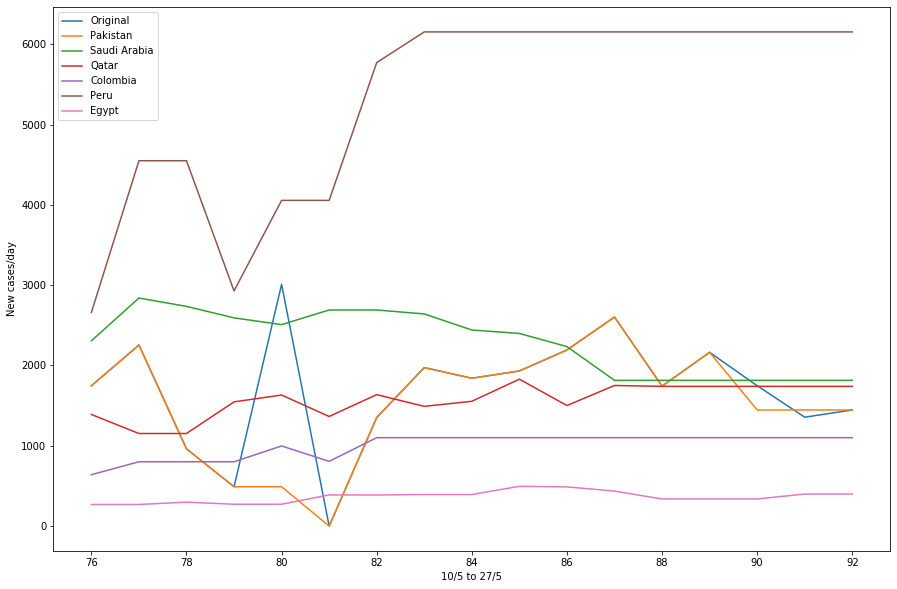

In [168]:
plt.rcParams['figure.figsize']=(15,10)
plt.plot(pak_data,pak_label)
legend=['Original']
for data in country_pred:
    plt.plot(pak_data,country_pred[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('10/5 to 27/5')
plt.ylabel('New cases/day')
plt.show()

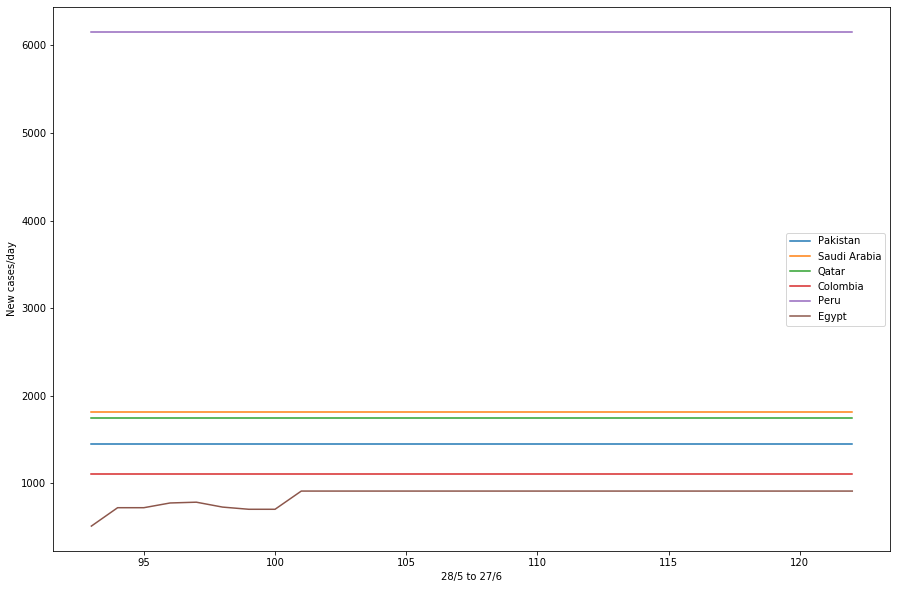

In [171]:
plt.rcParams['figure.figsize']=(15,10)
legend=[]
for data in month_pred:
    plt.plot(pred_days,month_pred[data])
    legend.append(data)
plt.legend(legend)
plt.xlabel('28/5 to 27/6')
plt.ylabel('New cases/day')
plt.show()

In [181]:
class RNN(nn.Module):
    def __init__(self, n_steps, n_inputs, n_neurons, n_outputs):
        super(RNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.Lstm = nn.LSTM(self.n_inputs, self.n_neurons) 
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, __ = self.lstm(X, self.hidden)    
        
        return lstm_out # batch_size X n_output

In [ ]:
N_INPUTS = 1
N_NEURONS = 150
N_OUTPUTS = 1